In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

for root, dirs, files in os.walk(data_dir):
    print("Directory:", root)
    for d in dirs:
        print("  Subfolder:", d)
    for f in files[:5]:
        print("  File:", f)
    print()

In [6]:
# Import Libraries and Setup
import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
import pandas as pd
from collections import OrderedDict
import warnings
from scipy.stats import kurtosis, skew, ttest_ind
import os

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Verify GPU availability
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"TensorFlow GPU devices: {len(tf.config.experimental.list_physical_devices('GPU'))}")

2025-07-27 08:56:43.954017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753606604.240203      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753606604.321086      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PyTorch CUDA available: False
TensorFlow GPU devices: 0


2025-07-27 08:57:00.102416: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
!pip install nibabel

In [9]:
import nibabel as nib

image_path = "/kaggle/input/mri-dataset-for-detection-and-analysis/3D_volumetric_imaging/Walnut_CT_complete/walnut.nii"
image_nifti = nib.load(image_path)
image_volume = image_nifti.get_fdata()

print(image_volume.shape)
print(image_volume.dtype)
print(image_volume)

(400, 296, 352)
float64
[[[329. 288. 389. ... 402. 374. 334.]
  [433. 369. 261. ... 297. 215. 100.]
  [110. 121.  13. ... 155.   0.  23.]
  ...
  [218.  79. 109. ... 325. 291. 409.]
  [156. 154. 178. ... 313. 344. 263.]
  [ 22. 183. 327. ... 222. 330. 225.]]

 [[321. 273. 164. ... 178. 275. 298.]
  [380. 278. 130. ... 410. 317. 204.]
  [103. 102.   7. ... 190.   0.   3.]
  ...
  [403. 345. 295. ... 499. 360. 296.]
  [189. 333. 540. ... 201. 249. 280.]
  [ 46. 340. 625. ...  94. 184. 281.]]

 [[437. 387. 304. ... 155. 219. 311.]
  [470. 381. 332. ... 127. 167. 261.]
  [ 61.  21.   0. ...  94.  70. 208.]
  ...
  [397. 502. 497. ... 362. 406. 356.]
  [297. 421. 448. ... 192. 274. 395.]
  [471. 343. 270. ... 119. 112. 286.]]

 ...

 [[ 99.  50.  31. ... 505. 466. 419.]
  [173. 215. 214. ... 186. 252. 247.]
  [396. 423. 457. ... 169. 270. 398.]
  ...
  [192. 112.  40. ...   1.   0.  58.]
  [130. 188. 196. ...  80. 156. 178.]
  [ 92. 257. 286. ... 257. 314. 295.]]

 [[ 55. 136.  91. ... 302.

In [ ]:
import nibabel as nib

mask_path = "/kaggle/input/mri-dataset-for-detection-and-analysis/3D_volumetric_imaging/Walnut_CT_masked/walnut_masked.nii"
mask_nifti = nib.load(mask_path)
mask_volume = mask_nifti.get_fdata()

print(mask_volume.shape)
print(mask_volume.dtype)
print(mask_volume)

In [12]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2

# Normalize and resize each 2D slice
image_slices = []
mask_slices = []

for i in range(image_volume.shape[2]):
    img_slice = image_volume[:, :, i]
    mask_slice = mask_volume[:, :, i]

    # Normalize to 0-1 range and resize
    img = cv2.resize(img_slice, (256, 256)) / 255.0
    mask = cv2.resize(mask_slice, (256, 256)) / 255.0

    image_slices.append(img)
    mask_slices.append(mask)

# Convert to numpy arrays
image_slices = np.array(image_slices)
mask_slices = np.array(mask_slices)

# Train/Val split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_slices, mask_slices, test_size=0.2, random_state=42
)

# PyTorch Dataset
class MRIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return torch.FloatTensor(img), torch.FloatTensor(mask)

# Albumentations transformations
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

# Create datasets and loaders
train_dataset = MRIDataset(train_imgs, train_masks, transform=transform)
val_dataset = MRIDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))

Train set size: 281
Validation set size: 71


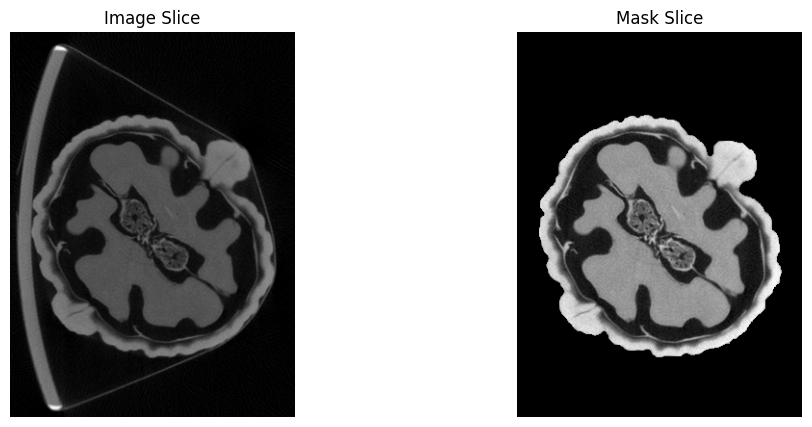

In [14]:
import matplotlib.pyplot as plt

slice_idx = image_volume.shape[2] // 2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_volume[:, :, slice_idx], cmap='gray')
plt.title("Image Slice")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_volume[:, :, slice_idx], cmap='gray')
plt.title("Mask Slice")
plt.axis("off")

plt.show()

In [15]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2

# Normalize and resize each 2D slice
image_slices = []
mask_slices = []

for i in range(image_volume.shape[2]):
    img_slice = image_volume[:, :, i]
    mask_slice = mask_volume[:, :, i]

    # Normalize to 0-1 range and resize
    img = cv2.resize(img_slice, (256, 256)) / 255.0
    mask = cv2.resize(mask_slice, (256, 256)) / 255.0

    image_slices.append(img)
    mask_slices.append(mask)

# Convert to numpy arrays
image_slices = np.array(image_slices)
mask_slices = np.array(mask_slices)

# Train/Val split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_slices, mask_slices, test_size=0.2, random_state=42
)

# PyTorch Dataset
class MRIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return torch.FloatTensor(img), torch.FloatTensor(mask)

# Albumentations transformations
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

# Create datasets and loaders
train_dataset = MRIDataset(train_imgs, train_masks, transform=transform)
val_dataset = MRIDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))

Train set size: 281
Validation set size: 71
